# Reaching Movement with internal model of gravity

# Import

In [3]:
from Basic_Model import *
from Newton import *
from FF_Helpers import *
plt.rcParams["figure.figsize"] = (10,10)
import matplotlib as mpl

# Code

In [4]:
def get_Gravity_Matrix(x,g,ghat,alpha):
    """
    return the gravity matrices terms
    """
    Ms = 50
    Ls = 1.6
    m1 = Ms*0.028
    m2 = Ms*0.022
    l1 = Ls*0.186
    l2 = Ls*(0.146)
    lc1 = l1*0.436
    lc2 = l2*0.682
    I1 = m1*(l1*0.322)*(l1*0.322)
    I2 = m2*(l2*0.468)*(l2*0.468)
 
    G = np.array([g*(m1*lc1*np.cos(x[0]+alpha)+m2*(lc2*np.cos(x[0]+alpha+x[1])+l1*np.cos(x[0]+alpha))),
                    g*m2*lc2*np.cos(x[0]+x[1]+alpha)])
    Ghat = np.array([ghat*(m1*lc1*np.cos(x[0]+alpha)+m2*(lc2*np.cos(x[0]+alpha+x[1])+l1*np.cos(x[0]+alpha))),
                    ghat*m2*lc2*np.cos(x[0]+alpha+x[1])])
    Ghatdot = np.array([ghat*(-m1*lc1*np.sin(x[0]+alpha)*x[2]+m2*(-lc2*np.sin(x[0]+alpha+x[1])*(x[2]+x[3])-l1*np.sin(x[0]+alpha)*x[2])),
                    -ghat*m2*lc2*np.sin(x[0]+alpha+x[1])*(x[2]+x[3])])
    return G,Ghat,Ghatdot

In [141]:
def Simulation_Gravity(w1,w2,w3,w4,r1,r2,targets = [0,55],starting_point = [0,30],plot = True,g = 9.81,ghat = 9.81,color = "black",Label = None,alpha = 0,newton_start = np.array([0.8,1.5])):
    """
    Parameters : 
    w1 : Weight of the cost function regarding the shoulder angle
    w2 : Weight of the cost function regarding the elbow angle
    r1 : Weight of the cost function regarding the shoulder angular velocity
    r2 : Weight of the cost function regarding the elbow angular velocity
    targets : X,Y Coordinates of the targets in cm 
    starting_point : X,Y Coordinates of the starting_point in cm 
    plot : Boolean for allowing to plot the simulation  
    g : through gravity constant
    ghat : internal estimate of the gravity constant
    color : color of the lineplot 
    Label : label of the lineplot
    alpha : Angle between the body position and the vertical, = 0 when we sit, = -pi/2 in horizontal position (couché)

    """

    Num_iter = 350
    dt = 0.001

    #Compute starting angle and target angle from their cardinal positions

    st1,st2 = newton(f,df,1e-8,1000,starting_point[0],starting_point[1],x0 = newton_start)
    obj1,obj2 = newton(f,df,1e-8,1000,targets[0],targets[1],x0 = newton_start)
    Angles = [st1,st2,obj1,obj2]
    for i in range(len(Angles)):
        while Angles[i] < 0: Angles[i]+=2*np.pi
        if Angles[i] > np.pi : Angles[i]-=2*np.pi #Au cas où ca fait des trop grand écarts d'angle décalé de 2pi
    st1,st2,obj1,obj2 = Angles


    #Initial arrays

    xstart = np.array([st1,0,0,st2,0,0,obj1,0,obj2,0])
    x0 = np.array([st1,0,0,st2,0,0,obj1,0,obj2,0])
    xnonlin0 = np.concatenate((x0[:7],np.array([x0[8]])))
    Bruit = True #J'ai mis une variance très faible au bruit pour avoir des mouvements non bruité
    NbreVar = 8
    
    #Define Weight Matrices
    Rnonlin = np.array([[r1,0],[0,r2]])
    Qnonlin = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])
    
    
    
    #Define Dynamic Matrices  
    Az = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    Bz = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    
    
    #Reverse Iterations of LQG
    #print(Qnonlin.astype(int))
    S = Qnonlin

    
    array_L = np.zeros((Num_iter-1,2,NbreVar))   
    array_S = np.zeros((Num_iter,NbreVar,NbreVar)) 
    array_S[-1] = Qnonlin
    for k in range(Num_iter-1):
        L = np.linalg.inv(Rnonlin+Bz.T@S@Bz)@Bz.T@S@Az
        array_L[Num_iter-2-k] = L
        S = Az.T@S@(Az-Bz@L)
        array_S[Num_iter-2-k] = S
        
    
    #Define variable array for stockage
    H,L,x0,A,B = np.identity(8),array_L,xnonlin0,Az,Bz
        
    array_x = np.zeros((Num_iter,NbreVar))
    array_xhat = np.zeros((Num_iter,NbreVar))
    array_reelx = np.zeros((Num_iter,NbreVar-2)) 
    y = np.zeros((Num_iter,NbreVar))

    array_x[0] = x0.flatten()
    array_xhat[0] = x0.flatten()
    xhat = x0
    x = x0
    reelx = np.zeros(NbreVar-2)
    reelx[0] = x[0]
    reelx[1] = x[3]
    new_reelx = reelx
    sigma = np.identity(NbreVar)*10**-6
    tau = np.zeros(2)
    
    
    for k in range(Num_iter-1):
        acc = np.array([(reelx[2]-array_reelx[k-1][2])/dt,(reelx[3]-array_reelx[k-1][3])/dt]) #Angular acceleration
        

        x[0],x[1],x[3],x[4] = reelx[0],reelx[2],reelx[1],reelx[3]
        x[2] = acc[0]
        x[5] = acc[1]  

        #Change of variable, x,xhat,y = variable in linear model, reelx = variable in nonlinear model
        Omega_sens,motor_noise,Omega_measure,measure_noise = Bruitage(Bruit,NbreVar) 
        y[k] = (H@x+measure_noise).flatten()
        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        v = -L[k].reshape(np.flip(B.shape))@xhat 
       
        
        sigma = Omega_sens + (A - K@H)@sigma@A.T
        xhat = A@xhat + B@v + K@(y[k]-H@xhat)
        x = A@x+B@v+motor_noise

        
        #Computation of the matrices used in the nonlinear system 

        C = np.array([-reelx[3]*(2*reelx[2]+reelx[3])*a2*np.sin(reelx[1]),reelx[2]*reelx[2]*a2*np.sin(reelx[1])])
        Denominator = a3*(a1-a3)-a2*a2*np.cos(reelx[1])*np.cos(reelx[1])
        Minv = np.array([[a3/Denominator,(-a2*np.cos(reelx[1])-a3)/Denominator],[(-a2*np.cos(reelx[1])-a3)/Denominator,(2*a2*np.cos(reelx[1])+a1)/Denominator]])
        
        M = np.array([[a1+2*a2*cos(reelx[1]),a3+a2*cos(reelx[1])],[a3+a2*cos(reelx[1]),a3]])
        Minvdot = np.array([[-a3*a2*a2*sin(2*reelx[1])*reelx[3]/(Denominator*Denominator),
                             (a2*sin(reelx[1])*reelx[3]*Denominator+(a2*cos(reelx[1])+a3)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator)],
                            [(a2*sin(reelx[1])*reelx[3]*Denominator+(a2*cos(reelx[1])+a3)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator),
                            (-2*a2*sin(reelx[1])*reelx[3]*Denominator+(2*a2*cos(reelx[1])+a1)*a2*a2*sin(2*reelx[1])*reelx[3])/(Denominator*Denominator)]])
        G,Ghat,Ghatdot =  get_Gravity_Matrix(reelx,g,ghat,alpha)
        
            
        Cdot = np.array([-a2*x[5]*(2*x[1]+x[4])*sin(x[3])-a2*x[4]*(2*x[2]+x[5])*sin(x[3])
                         -a2*x[4]*x[4]*(2*x[1]+x[4])*cos(x[3]),2*x[1]*x[2]*a2*sin(x[3])+x[1]*x[1]*a2*cos(x[3])*x[4]])
        K = 1/0.06
        
        COLORS = color
        dottau = M@(v-Minvdot@M@np.array([x[2],x[5]]))+Cdot+Ghatdot+Bdyn@np.array([x[2],x[5]])

        tau = M@np.array([x[2],x[5]])+C+Bdyn@np.array([x[1],x[4]])+Ghat
        u = dottau/K + tau 

        #Simulation of the dynamics knowing the command 

        new_reelx[0:2] += dt*reelx[2:4] #Angle
        new_reelx[2:4] += dt*(Minv@(reelx[4:6]-Bdyn@(reelx[2:4])-C-G))  #Angular velocity 
        new_reelx[4:6] += dt*K*(u-reelx[4:6]) #Muscle Torque 
            
        array_xhat[k+1] = xhat.flatten()
        array_x[k+1]= x.flatten()
        reelx = new_reelx 
        array_reelx[k+1] = new_reelx.flatten()

#Plot
    x0 = xstart
    reelx = array_reelx.T[:,1:][:,::1]
    #alpha = 0
    X = np.cos(reelx[0]+reelx[1]+alpha)*33+np.cos(reelx[0]+alpha)*30
    Y = np.sin(reelx[0]+reelx[1]+alpha)*33+np.sin(reelx[0]+alpha)*30
    if plot : 
        plt.scatter([np.cos(obj1+obj2+alpha)*33+np.cos(obj1+alpha)*30],[np.sin(obj1+obj2+alpha)*33+np.sin(obj1+alpha)*30],color = "red")
        plt.plot(X,Y,color = color,linewidth = .8, label = Label)
    return True

# Simulation

Text(0.5, 1.0, 'Target reaching for multiple internal estimation of gravity')

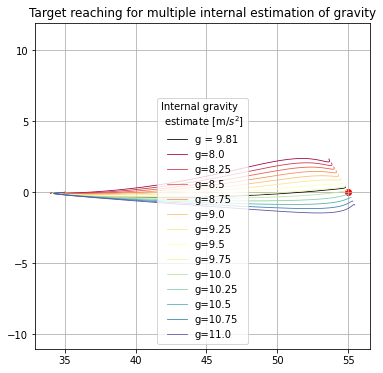

In [25]:
plt.grid()
plt.axis("equal")
Simulation_Gravity(1e7,1e6,1000,1000,1e-6,1e-6,starting_point= [0,35],targets = [0,55],color = "black",Label = "g = 9.81")

n_lines = 13
cmap = mpl.colormaps['Spectral']# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))
for ghat in np.linspace(8,11,13):
    Simulation_Gravity(1e7,1e6,1000,1000,1e-6,1e-6,starting_point= [0,35],targets = [0,55],ghat = ghat,color = colors[int((ghat-8)*4)],Label="g="+str(ghat))
plt.legend(title = "Internal gravity\n estimate [m/$s^2$]")
plt.scatter([55],[0],color = "red")
plt.title("Target reaching for multiple internal estimation of gravity")

Text(0.5, 1.0, 'Target reaching for multiple internal estimation of gravity')

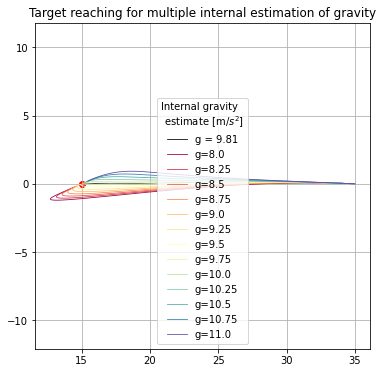

In [23]:
plt.grid()
plt.axis("equal")
Simulation_Gravity(1e7,1e8,1000,1000,1e-6,1e-6,starting_point= [0,35],targets = [0,15],color = "black",Label = "g = 9.81")

n_lines = 13
cmap = mpl.colormaps['Spectral']# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))
for ghat in np.linspace(8,11,13):
    Simulation_Gravity(1e7,1e8,1000,1000,1e-6,1e-6,starting_point= [0,35],targets = [0,15],ghat = ghat,color = colors[int((ghat-8)*4)],Label="g="+str(ghat))
plt.legend(title = "Internal gravity\n estimate [m/$s^2$]")
plt.scatter([15],[0],color = "red")
plt.title("Target reaching for multiple internal estimation of gravity")


## Assis

-1.1587226680303908 1.7172792141583706


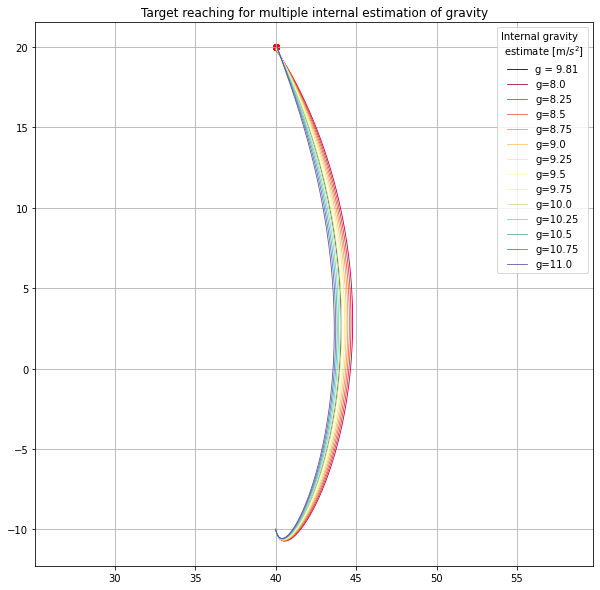

-1.1647284757392915 2.1531605646646583


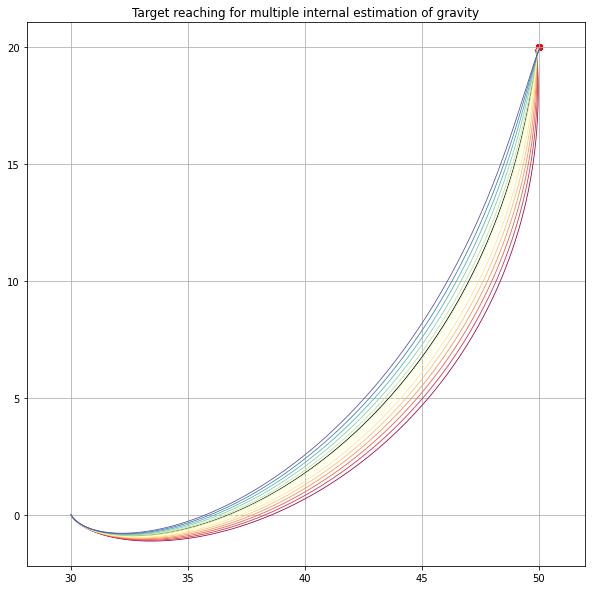

-0.2297140607630671 2.4219179760848277


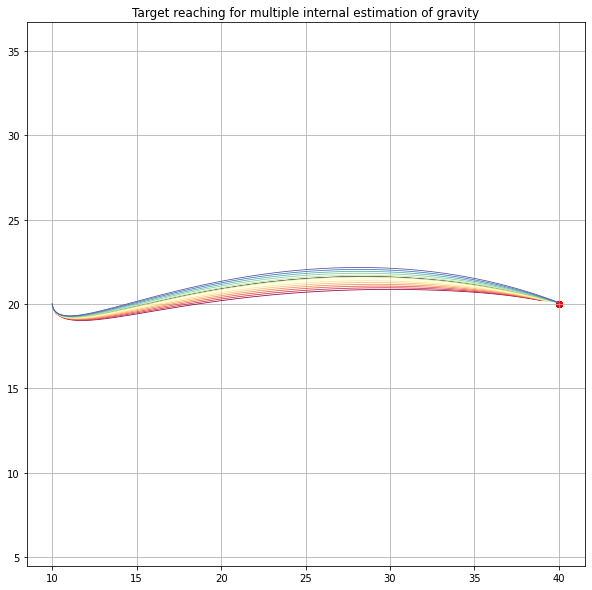

In [143]:
alpha = 0
for idx,rotate_target in enumerate([0,np.pi/4,np.pi/2]):
        st = [[40,-10],[30,0],[10,20]][idx]
        tg = [[40,20],[50,20],[40,20]][idx]
        st1,st2 = newton(f,df,1e-8,1000,st[0],st[1],x0=[0,np.pi/2])
        print(st1,st2)
        stsearch = np.array([0,np.pi/2])
        obj1,obj2 = newton(f,df,1e-8,1000,tg[0],tg[1])
        plt.rcParams["figure.figsize"] = (10,10)
        plt.grid()
        plt.axis("equal")
        Simulation_Gravity(1e5,1e6,1000,1000,1e-6,1e-6,starting_point= st,targets = tg,color = "black",Label = "g = 9.81",alpha = alpha,newton_start=stsearch)

        n_lines = 13
        cmap = mpl.colormaps['Spectral']# Take colors at regular intervals spanning the colormap.
        colors = cmap(np.linspace(0, 1, n_lines))
        for ghat in np.linspace(8,11,13):
            Simulation_Gravity(1e5,1e6,1000,1000,1e-6,1e-6,starting_point= st,targets = tg,ghat = ghat,color = colors[int((ghat-8)*4)],Label="g="+str(ghat),alpha = alpha,newton_start=stsearch)
        if alpha == 0 and rotate_target == 0:
            plt.legend(title = "Internal gravity\n estimate [m/$s^2$]")
        #plt.scatter([0],[55],color = "red")
        plt.title("Target reaching for multiple internal estimation of gravity")
        plt.show()

## Corps à 45°

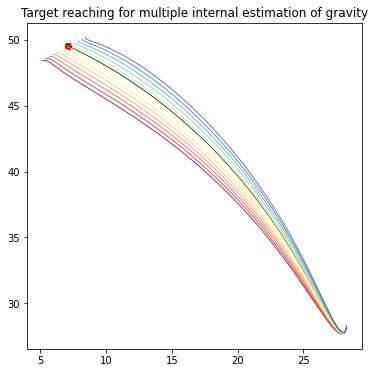

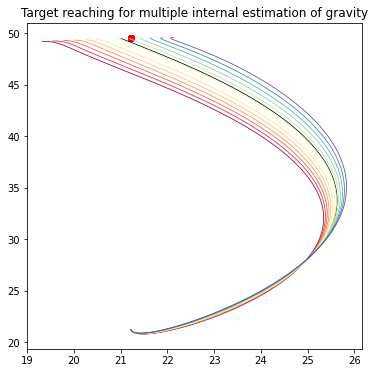

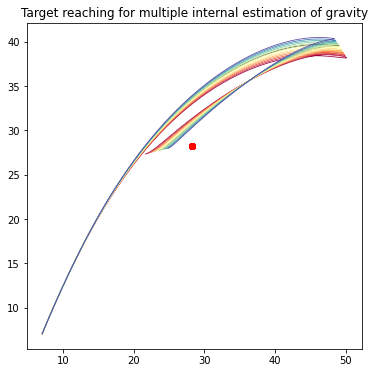

In [144]:
alpha = pi/4
for idx,rotate_target in enumerate([0,np.pi/4,np.pi/2]):
        st = [[40,0],[30,0],[10,0]][idx]
        tg = [[40,30],[50,20],[40,0]][idx]
        st1,st2 = newton(f,df,1e-8,1000,st[0],st[1],x0=[0,np.pi/2])
        stsearch = np.array([0,np.pi/2])
        obj1,obj2 = newton(f,df,1e-8,1000,tg[0],tg[1],x0=[0,np.pi/2])
        plt.rcParams["figure.figsize"] = (6,6)
        plt.grid
        Simulation_Gravity(1e7,1e6,1000,1000,1e-6,1e-6,starting_point= st,targets = tg,color = "black",Label = "g = 9.81",alpha = alpha,newton_start = stsearch)

        n_lines = 13
        cmap = mpl.colormaps['Spectral']# Take colors at regular intervals spanning the colormap.
        colors = cmap(np.linspace(0, 1, n_lines))
        for ghat in np.linspace(8,11,13):
            Simulation_Gravity(1e7,1e6,1000,1000,1e-6,1e-6,starting_point= st,targets = tg,ghat = ghat,color = colors[int((ghat-8)*4)],Label="g="+str(ghat),alpha = alpha,newton_start = stsearch)
        if alpha == 0 and rotate_target == 0:
            plt.legend(title = "Internal gravity\n estimate [m/$s^2$]")
        #plt.scatter([0],[55],color = "red")
        plt.title("Target reaching for multiple internal estimation of gravity")
        plt.show()

## Couché

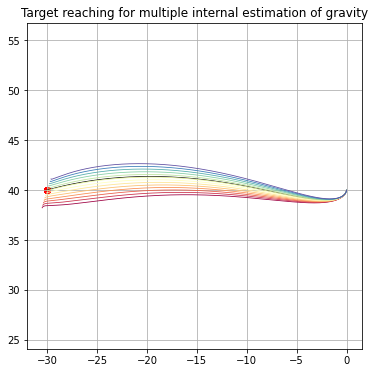

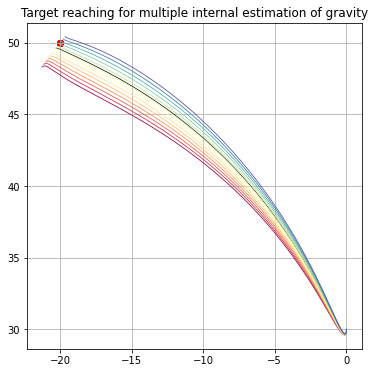

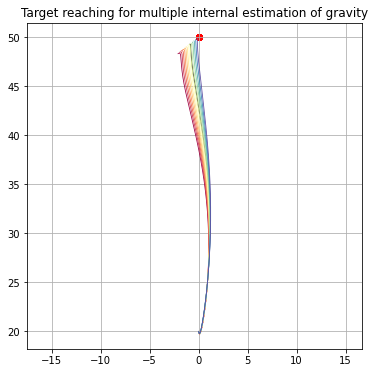

In [139]:
alpha = pi/2
for idx,rotate_target in enumerate([0,np.pi/4,np.pi/2]):
        st = [[40,0],[30,0],[20,0]][idx]
        tg = [[40,30],[50,20],[50,0]][idx]
        st1,st2 = newton(f,df,1e-8,1000,st[0],st[1],x0=[0,np.pi/2])
        stsearch = np.array([0,np.pi/2])
        obj1,obj2 = newton(f,df,1e-8,1000,tg[0],tg[1],x0=[0,np.pi/2])
        plt.rcParams["figure.figsize"] = (6,6)
        plt.grid()
        plt.axis("equal")
        Simulation_Gravity(1e7,1e6,1000,1000,1e-6,1e-6,starting_point= st,targets = tg,color = "black",Label = "g = 9.81",alpha = alpha,newton_start = stsearch)
        n_lines = 13
        cmap = mpl.colormaps['Spectral']# Take colors at regular intervals spanning the colormap.
        colors = cmap(np.linspace(0, 1, n_lines))
        for ghat in np.linspace(8,11,13):
            Simulation_Gravity(1e7,1e6,1000,1000,1e-6,1e-6,starting_point= st,targets = tg,ghat = ghat,color = colors[int((ghat-8)*4)],Label="g="+str(ghat),alpha = alpha,newton_start=stsearch)
        if alpha == 0 and rotate_target == 0:
            plt.legend(title = "Internal gravity\n estimate [m/$s^2$]")
        #plt.scatter([0],[55],color = "red")
        plt.title("Target reaching for multiple internal estimation of gravity")
        plt.show()